![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Seq2Seq Basics

## Introduction 
This tutorial demonstrates the process of building `LSTM Sequence to Sequence` (`Seq2Seq`) model with the univariate time series data.<br>
## What will we accomplish?
1. Understand the configuration of `Seq2Seq` model
2. Able to use `Seq2Seq` model to perform the single step and multi-step forecast for univariate data.
3. Able to use `Pytorch` Custom Dataset to perform the sliding window function.

## Notebook Outline
Below is the outline for this tutorial
1. [Hyperparameter](#Hyperparameter)
2. [Create dataset](#Createdataset)
3. [Data Visualization](#DataVisualization)
4. [Data Splitting](#DataSpliting)
5. [Data Scaling ](#DataScaling )
6. [Data Transform](#DataTransform)
7. [Data Sequencing](#DataSequencing)
8. [Data Iterator](#DataIterator)
9. [Model building](#Modelbuilding)
10. [Input Model](#InputModel)
11. [Training](#Training)
12. [Model Evaluation](#ModelEvaluation)
    * [Inverse Scale Transform](#InverseScaleTransform)
    * [Forecast Data Evaluation](#ForecastDataEvaluation)
    * [Forecast Plot](#ForecastPlot)
13. [Summary](#Summary)
14. [Reference](#Reference)
***Note***
1. Detailed instructions are available in the cells below.
2. You are required to provide the answer below the comment.
`# YOUR CODE HERE.`
3. Only make changes to the part with the comment
`# YOUR CODE HERE.`

First, let's import the package needed.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from torchsummaryX import summary
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math

## <a name="Hyperparameter">Hyperparameter

In [2]:
num_futures = 3
window_size= 40
batch_size= 5
split_ratio = 0.7
num_epochs = 10

## <a name="Createdataset">Create dataset
Create a sine wave synthetic data

In [3]:
# Create synthetic data
x= torch.linspace(0,799,800)
y = torch.sin(x*2*3.1416/40)

## <a name="DataVisualization">Data Visualization

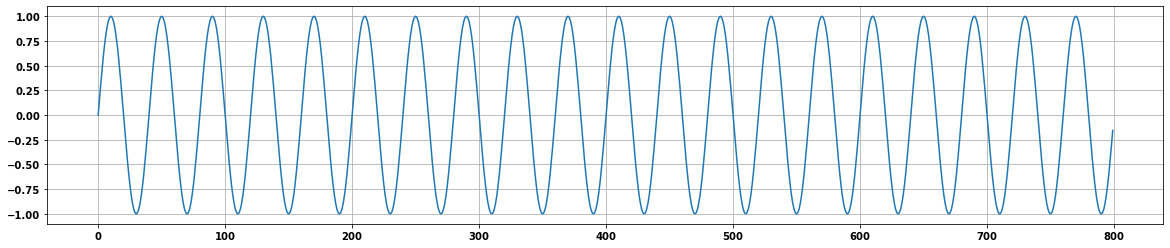

In [4]:
plt.figure(figsize=(20,4))
plt.plot(x, y)
plt.grid(True)
plt.show()

## <a name="DataSpliting">Data Splitting

In [5]:
train, test =  train_test_split(y,train_size = split_ratio, shuffle=False)

In [6]:
train_axis = x[:len(train)]
test_axis = x[len(train):]

## <a name="DataScaling ">Data Scaling 
Perform normalization to the data
>**Instruction** : <br>
Use `MinMaxScaler()` as the scaler for the data. Create scaled data using `scaler.transform` and store in respective `train_norm` and `test_norm`

In [7]:
### BEGIN SOLUTION
# Scaler the data
scaler = MinMaxScaler().fit(train.reshape(-1,1))
train_norm = scaler.transform(train.reshape((-1,1)))
test_norm = scaler.transform(test.reshape((-1,1)))
### END SOLUTION

## <a name="DataTransform">Data Transform

In [8]:
train_norm = torch.from_numpy(train_norm).type(torch.Tensor)
test_norm = torch.from_numpy(test_norm).type(torch.Tensor)

## <a name="DataSequencing">Data Sequencing
    
>**Instruction** : <br>
Use `Pytorch Custom Dataset` class to perform the window sliding. 

>*Hints*<br>
    1. Initialize using `def __init__(self, series, window_size, num_future_pt)`   
    2. Create `__getitem__(self, idx):` method.<br>
    3. Create `def __len__(self):` method.<br>

In [9]:
class SineDataSet(Dataset):
    def __init__(self, series, window_size, num_future_pt):
        ### BEGIN SOLUTION
        self.series = series
        self.window_size = window_size
        self.num_future_pt = num_future_pt
        self.shape = self.__getshape__()
        
    def __getitem__(self, idx):
        X = self.series[idx: idx + self.window_size]
        y = self.series[idx + self.window_size:idx+ self.window_size + self.num_future_pt]
        return X,y
    
    def __len__(self):
        return len(self.series) - self.window_size - self.num_future_pt
    
    # add this method to able access the shape
    def __getshape__(self):
        return (self.__len__(),*self.__getitem__(0)[0].shape,*self.__getitem__(0)[1].shape)
    ### END SOLUTION

In [10]:
train_ds = SineDataSet(train_norm, window_size, num_futures)
test_ds  = SineDataSet(test_norm, window_size, num_futures)

Perform sanity check to the shape to ensure `Pytorch Custom Dataset` created correctly.<br>
**Option 1: Define a method called `__getshape__` to make the object able to print the data shape.**

In [11]:
print(train_ds.shape)

(517, 40, 1, 3, 1)


**Option 2: Use `__getitem__` to get the data shape**

In [12]:
feature, label = train_ds.__getitem__(0)
print("Feature shape:" + str(feature.shape))
print("Label shape:" + str(label.shape))
print("\nThe first dimension of the feature should be the same as the window size that we defined earlier.")
print("\nThe label's first dimension should be the same as the number of future time steps we defined earlier")
print("Window Size: " + str(window_size))
print("Number of future time step: "+ str(num_futures))
print(f"First dimension of the feature = {feature.shape[0]} and label = {label.shape[0]}")

Feature shape:torch.Size([40, 1])
Label shape:torch.Size([3, 1])

The first dimension of the feature should be the same as the window size that we defined earlier.

The label's first dimension should be the same as the number of future time steps we defined earlier
Window Size: 40
Number of future time step: 3
First dimension of the feature = 40 and label = 3


## <a name="DataIterator">Data Iterator

In [13]:
train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Perform sanity check to the shape to ensure data iterator created correctly.

In [14]:
feature_iter , label_iter = next(iter(train_loader))
print("Feature shape:" + str(feature_iter.shape))
print("Label shape:" + str(label_iter.shape))
print("\nThe first dimension of the feature and label should be same as the batch size that we define earlier.")
print("Batch Size:" + str(batch_size))
print(f"First dimension of the feature = {feature_iter.shape[0]} and label = {label_iter.shape[0]}")

Feature shape:torch.Size([5, 40, 1])
Label shape:torch.Size([5, 3, 1])

The first dimension of the feature and label should be same as the batch size that we define earlier.
Batch Size:5
First dimension of the feature = 5 and label = 5


## <a name="Model building">Model building (Univariate Seq2Seq)

>**How to initialize LSTM?**<br>
 1.`nn.LSTM(number of feature , number of hidden unit,number of layer)`<br>
 2.`nn.Linear(number of hidden, number of step)`<br>

>**The dimension for LSTM in the `forward()` method (Data Flow Protocol)**<br>
*Input*<br>
`input(batch size,sequence length, number of feature)`<br>
`h_0 (1, batch size, number of hidden unit)`<br>
`c_0 (1, batch size, number of hidden unit)`<br><br>
*Output*<br>
`output ( batch,seq_len, num_directions * hidden_size)`<br>
`h_n (1, batch size,  number of hidden unit)`<br>
`c_n (1, batch size,  number of hidden unit)`<br><br>

>**How to Seq2Seq work**<br>
![image](https://user-images.githubusercontent.com/59526258/118959050-8a359d80-b994-11eb-8d82-47f3443bd3af.png)
**Encoder**<br>
    1. A stack of several recurrent units (it can be RNN, LSTM or GRU) where each unit accepts a single element of the input sequence.<br>
    2. All the outputs will be discarded, and only the internal states (hidden state) preserved.<br>
    3. Pass the hidden states to the decoder.<br>
**Encoder Vector**<br>
    1. This is the final hidden state produced from the model's Encoder part.<br>
    2. It acts as the initial hidden state of the decoder part of the model.<br>
    3. In practice, this does not exist, and all we need to do is input our hidden state from Encoder to decoder. <br>
**Decoder**<br>
    1. Each recurrent unit accepts a hidden state from the previous unit and output.<br> 
    2. The initial states are initialized from the final states of the Encoder. <br>
    
>**Model Structure**<br>    
<img src = "../../picture/seq2seq.png" align="center" />
The seq2seq model configuration contains three parts which are `EncoderRNN`,`DecoderRNN`, and `Seq2Seq`.<br>

>**Pipeline for `EncoderRNN`**<br>
In `EncoderRNN`, the configuration is identical to the configuration of `LSTM`. Instead of returning the output of `LSTM`, it returns the hidden state (`hidden`) only. The hidden will pass to `DecoderRNN` as input of it.

>**Pipeline for `DecoderRNN`**<br>
In `DecoderRNN`, the initialization is the same as `EncoderRNN` and extra instances such as the number of output (`num_output`) and a linear layer acting as a fully connected layer. The `DecoderRNN` takes two input arguments in the `forward` method: the previous time step and hidden state from `EncoderRNN`. It returns the output and hidden state for the next decoder unit if there is any future step to predict.

>**Pipeline for `Seq2Seq`**<br>
In the `Seq2Seq`, it used to combine and control the data flow for both `EncoderRNN` and `DecoderRNN`. In the initialization, it involves the primary instance for `LSTM` and both `EncoderRNN` and `DecoderRNN` class. In the `forward` method, the sequence data will input to `EncoderRNN` and return as the hidden state. The last time step of sequence data will become the input of the `DecoderRNN`. An empty place holder created to hold the output from the `DecoderRNN`. Lastly, a for loop  created to repeat the decoder unit if the user wishes to predict more than one time step (as known as multi-step prediction)


>**Model Structure for Multi Step Prediction**<br> 
In the `Seq2seq` model, the multi-step prediction is required to feeds the previous prediction to the decoder to predict the future time step.
![image](../../picture/seq2seq_single_step.png)
![image](../../picture/seq2seq_timestep2.png)
![image](../../picture/seq2seq_multistep.svg)

>**Instruction** : <br>
Create configuration for `EncoderRNN`,`DecoderRNN`,`Seq2Seq`
    
>**Expected Result :**<br>
![image](https://user-images.githubusercontent.com/59526258/119097595-81ea6a80-ba47-11eb-9f49-3521495c747e.png)

In [15]:
class EncoderRNN(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, num_features, num_hidden):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size, batch_first=True)
        
     
    def forward(self, seq):
        h0 = torch.zeros(1, seq.size(0), self.hidden_size)
        c0 = torch.zeros(1, seq.size(0), self.hidden_size)
        out_lstm, hidden = self.lstm(seq, (h0.detach(),c0.detach()))
    ### END SOLUTION
        return hidden

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super().__init__()
        ### BEGIN SOLUTION
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = num_features
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        
    def forward(self, seq, hidden):
        out_lstm, out_hidden = self.lstm(seq, hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        out = torch.unsqueeze(out,2)
        ### END SOLUTION
        return out, out_hidden

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures):
        super().__init__()
        ### BEGIN SOLUTION
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures
        
        
        self.encoder = EncoderRNN(self.num_features, self.num_hidden)
        self.decoder = DecoderRNN(self.num_features, self.num_hidden, self.num_output)
        

    
    def forward(self, seq, prev_y):
        encoder_hidden = self.encoder(seq)  
        prev_hidden = encoder_hidden
        
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        
        #placeholder for decoder output
        targets_ta = []
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out)
        
        targets = torch.cat(targets_ta, dim=1)
        ### END SOLUTION
        return targets

## <a name="InputModel">Input Model

In [18]:
num_features = 1
num_hidden = 50
num_output = 1

model = Seq2Seq(num_features, num_hidden, num_output, num_futures)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

In [20]:
# Model Summary
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs,inputs[:,[-1],:]))

                        Kernel Shape Output Shape Params  Mult-Adds
Layer                                                              
0_encoder.LSTM_lstm                -  [5, 40, 50]  10.6k      10200
1_decoder.LSTM_lstm                -   [5, 1, 50]  10.6k      10200
2_decoder.Linear_linear      [50, 1]       [5, 1]   51.0         50
3_decoder.LSTM_lstm                -   [5, 1, 50]      -      10200
4_decoder.Linear_linear      [50, 1]       [5, 1]      -         50
5_decoder.LSTM_lstm                -   [5, 1, 50]      -      10200
6_decoder.Linear_linear      [50, 1]       [5, 1]      -         50
---------------------------------------------------------------------
                       Totals
Total params          21.251k
Trainable params      21.251k
Non-trainable params      0.0
Mult-Adds              40.95k
                        Kernel Shape Output Shape   Params  Mult-Adds
Layer                                                                
0_encoder.LSTM_lstm         

## <a name="Training">Training
Pipeline :
- Initialize epoch loss and running loss to zero for later use
- Forward Pass
- Calculate MSE
- Zero out optimizer gradient 
- Backward Pass
- Optimizer update 
- Compute running loss for each iteration
- Compute the epoch loss

>**Instruction** : <br>
Create the training function to train the model.

In [21]:

def training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    ### BEGIN SOLUTION
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cumulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for train_X,train_Y in train_iter:
            
            train_input = train_X[:,[-1],:]
            # Forward pass
            y_train_pred = model(train_X,train_input)
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for test_X,test_Y in test_iter:
                
                test_input = test_X[:,[-1],:]
                
                y_test_pred = model(test_X,test_input)
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    ### END SOLUTION
    return train_loss,val_loss

In [22]:
train_loss,val_loss = training(num_epochs,
                               train_loader,
                               test_loader,
                               optimizer,
                               criterion, 
                               model)

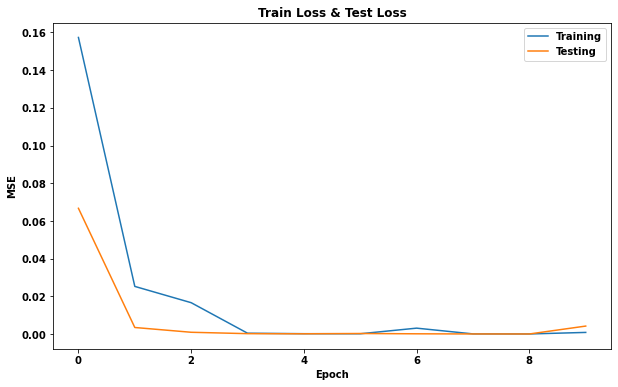

Epoch : 0 , training loss : 0.15732863006732342 , validation loss : 0.06672371034203145
Epoch : 1 , training loss : 0.025299253540240343 , validation loss : 0.003507737591088546
Epoch : 2 , training loss : 0.016664535848638206 , validation loss : 0.0009743700975192909
Epoch : 3 , training loss : 0.00047640692119614304 , validation loss : 0.0002391376292322961
Epoch : 4 , training loss : 0.00021687400613230745 , validation loss : 0.00017132051283541504
Epoch : 5 , training loss : 0.00018200293394906501 , validation loss : 0.0003189080693635813
Epoch : 6 , training loss : 0.0031599443378718998 , validation loss : 0.0001602073278789867
Epoch : 7 , training loss : 0.00011351733833945575 , validation loss : 8.333976915180636e-05
Epoch : 8 , training loss : 8.021049014157215e-05 , validation loss : 7.075239863745433e-05
Epoch : 9 , training loss : 0.0008958861388525487 , validation loss : 0.004258309417886737


In [23]:
def learning_curve(num_epochs,train_loss,val_loss):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Train Loss & Test Loss")
    plt.show()
    for i in range(num_epochs):
        print(f'Epoch : {i} , training loss : {train_loss[i]} , validation loss : {val_loss[i]}')
    
learning_curve(num_epochs,train_loss,val_loss)


## <a name="ModelEvaluation">Model Evaluation

In [24]:
with torch.no_grad():
    # Place holder
    predict_testset = []
    actual_testset = []
    predict_trainset = []
    actual_trainset= []
    
    # Iterate the train data iterator
    for idx in range(len(train_ds)):
        # Reshape to ensure the shape is match with requirement for LSTM model input
        train_feature = torch.unsqueeze(train_ds[idx][0],0)
        train_label = torch.unsqueeze(train_ds[idx][1],0)
        
        # Model Inferencing
        train_prediction = model(train_feature,train_feature[:,[-1],:])
        
        # Append the actual and predict data to the place holder
        actual_trainset.append(train_label)
        predict_trainset.append(train_prediction)
        
    # Iterate the test data iterator    
    for idx in range(len(test_ds)):
        # Reshape to ensure the shape is match with requirement for LSTM model input
        test_feature = torch.unsqueeze(test_ds[idx][0],0)
        test_label = torch.unsqueeze(test_ds[idx][1],0)
        
        # Model Inferencing
        test_prediction = model(test_feature,test_feature[:,[-1],:])
        actual_testset.append(test_label)
        
        # Append the actual and predict data to the place holder
        predict_testset.append(test_prediction)
        
# Concatenate the place holder 
trainset_actual_holder = torch.cat(actual_trainset,dim=0)
trainset_predict_holder = torch.cat(predict_trainset,dim=0)        
testset_actual_holder = torch.cat(actual_testset,dim=0)
testset_predict_holder = torch.cat(predict_testset,dim=0)

### <a name="InverseScaleTransform">Inverse Scale Transform

In [25]:
# Inverse Transform
trainset_actual = scaler.inverse_transform(trainset_actual_holder.reshape(-1,1))
trainset_predict = scaler.inverse_transform(trainset_predict_holder .reshape(-1,1))
testset_actual = scaler.inverse_transform(testset_actual_holder .reshape(-1,1))
testset_predict = scaler.inverse_transform(testset_predict_holder.reshape(-1,1))

In [26]:
# Reshape the inversed data
trainset_actual = trainset_actual.reshape(len(trainset_actual_holder),num_futures)
trainset_predict = trainset_predict.reshape(len(trainset_predict_holder),num_futures)
testset_actual = testset_actual.reshape(len(testset_actual_holder),num_futures)
testset_predict = testset_predict.reshape(len(testset_predict_holder),num_futures)

### <a name="ForecastDataEvaluation">Forecast Data Evaluation

In [27]:
print("Test Data\t\t\tForecast")
for test, forecast in zip(testset_actual,testset_predict):   
    print(f"{test}\t\t{forecast}")

Test Data			Forecast
[2.21490860e-04 1.56647682e-01 3.09224129e-01]		[-0.0157997   0.19399667  0.33183396]
[0.15664768 0.30922413 0.45418632]		[0.14126182 0.35570312 0.4943229 ]
[0.30922413 0.45418632 0.58796465]		[0.29856634 0.51279962 0.64888918]
[0.45418632 0.58796465 0.7072649 ]		[0.45331109 0.6618886  0.79186404]
[0.58796465 0.7072649  0.80914521]		[0.60206103 0.79922962 0.9195013 ]
[0.7072649  0.80914521 0.89110637]		[0.74070907 0.92082167 1.02808094]
[0.80914521 0.89110637 0.95112514]		[0.86460066 1.02258873 1.11405993]
[0.89110637 0.95112514 0.98772335]		[0.96891975 1.10071421 1.17430925]
[0.95112514 0.98772335 1.        ]		[1.04934454 1.1521225  1.20644903]
[0.98772335 1.         0.98765385]		[1.10276031 1.17497683 1.20921278]
[1.         0.98765385 0.95098782]		[1.12769651 1.16898847 1.18271852]
[0.98765385 0.95098782 0.89090466]		[1.1242516  1.13534212 1.1284852 ]
[0.95098782 0.89090466 0.80888402]		[1.09361959 1.07625484 1.04913855]
[0.89090466 0.80888402 0.70694542]		[1.03

In [28]:
# Calculate root mean squared error for both train and test data
trainScore = math.sqrt(mean_squared_error(trainset_actual, trainset_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testset_actual, testset_predict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.13 RMSE
Test Score: 0.13 RMSE


### <a name="ForecastPlot">Forecast Plot

In [29]:
def forecast_plot(actual,predict,test_axis,window_size,num_futures):
    # Forecast plot for single step forecast
    if num_futures == 1:
        plt.figure(figsize=(20,4))
        plt.grid()
        plt.plot(test_axis[window_size+1:],actual,'b',label="Test Data")
        plt.plot(test_axis[window_size+1:],predict,'r--',label="Forecast Data",linewidth=3.0)
        plt.legend()
        plt.title("Seq2Seq Single Step Forecast")
        
    else:
        # Forecast plot for multi-step forecast
        column_names = ["timestep_" + str(i) for i in range(num_futures)]
        y_test_dataframe = pd.DataFrame(actual,columns = column_names)
        y_test_pred_dataframe =pd.DataFrame(predict,columns = column_names)
        time_index_after_sequence = test_axis[window_size:]
        plt.figure(figsize=(20,4))
        
        # For loop to plot the data step by step base on time index    
        start_idx = 0 
        for row in range(len(y_test_dataframe)):

            # Iterate the time index after sequence
            time_index = time_index_after_sequence[start_idx:start_idx+num_futures]

            # Plot the test data
            plt.plot(time_index,y_test_dataframe.iloc[row],color="b",marker='o')

            # Plot the forecast data
            plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')

            # Pointer for time_index_after_sequence
            start_idx += 1

        custom_lines = [Line2D([0], [0], color="green", lw=4),
                    Line2D([0], [0], color="red", lw=4),]
        plt.legend(custom_lines, ['Test Data', 'Forecast Data'])
        plt.title("Seq2Seq Multi Step Forecast")

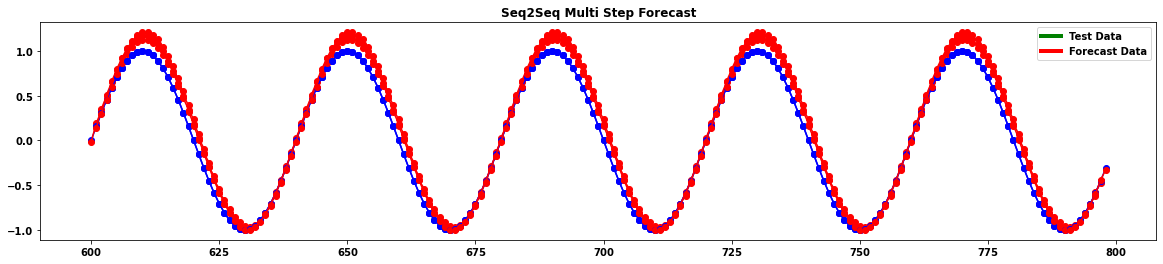

In [30]:
forecast_plot(testset_actual,testset_predict,test_axis,window_size,num_futures)

## <a name="Summary">Summary
From this tutorial, you should have learned:

1. The configuration of the `Seq2Seq` model.
2. Use the `Seq2Seq` model to perform single step and multi-step forecast for univariate data.
3. Use `Pytorch Custom Dataset` to perform the sliding window.

Congratulations, that concludes this lesson.<br>

## <a name="Reference">Reference
1. [DEPLOYING A SEQ2SEQ MODEL WITH TORCHSCRIPT](https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html)